In [23]:
from keras.datasets import boston_housing
import numpy as np
import seaborn as sns
from keras import models
from keras import layers


# 1. Load Boston housing price dataset:

- Boston housing price dataset is splited into train and validation set
- Train set has 404 records of 13 fields
- Test set has 102 records

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 3us/step


In [4]:
train_data.shape

(404, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
test_data.shape

(102, 13)

In [7]:
test_targets.shape

(102,)

In [11]:
np.max(train_targets)

50.0

In [12]:
np.min(train_targets)

5.0

/home/namntse05438/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


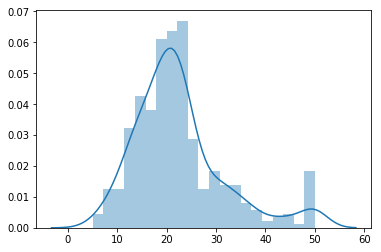

In [14]:
sns.distplot(train_targets)

/home/namntse05438/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


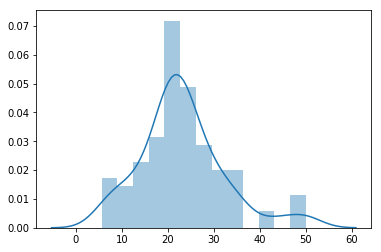

In [16]:
sns.distplot(test_targets)

In [17]:
# normalize data
def standard_scaling(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    norm_data = (data - mean) / std
    return norm_data
    

In [18]:
train_data_normalized = standard_scaling(train_data)

In [19]:
train_data_normalized

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [20]:
test_data_normalized = standard_scaling(test_data)

In [21]:
test_data_normalized

array([[ 2.8040301 , -0.50784934,  0.96960877, ...,  0.90513041,
        -4.27829517,  2.51324773],
       [-0.55530596, -0.50784934, -0.17801704, ..., -0.28485844,
         0.3909446 ,  0.58604286],
       [-0.56808398, -0.50784934, -0.86176938, ...,  0.90513041,
         0.41570668, -0.38506427],
       ...,
       [-0.23539182, -0.50784934,  1.17955762, ..., -1.82192738,
         0.32313459, -1.55879807],
       [-0.5113909 , -0.50784934, -0.71849348, ..., -0.48318992,
         0.34967446, -0.38956708],
       [-0.03148414, -0.50784934,  1.17955762, ..., -1.82192738,
        -1.57465677, -0.3745577 ]])

In [22]:
# 2. Define model

In [24]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [25]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [38]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 40
all_scores = []

all_mae_histories = []

In [40]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                            train_data[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
            validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [41]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

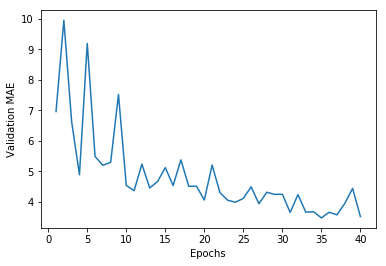

In [42]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

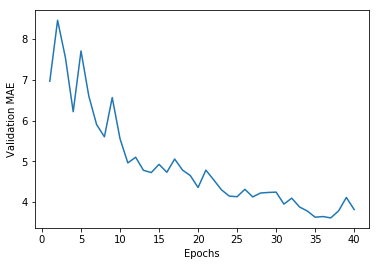

In [45]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[:], 0.5)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()